# Homework, first milestone

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://gist.github.com/kemvagyok/0481fa75e70dd18f5a1a11fa6ddf108d)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

## Data download (script)

### Colab case: (docker konténer esetét majd később, mert a feladat nem kérte)

In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json

In [ ]:
# Kaggle API setup
!pip install -q kaggle

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Download and unzip
DATA_DIR = "/content/airbus_data"
!mkdir -p {DATA_DIR}
!kaggle competitions download -c airbus-ship-detection -p {DATA_DIR} || echo "Competition not accessible"
!unzip -q -o "{DATA_DIR}/*.zip" -d "{DATA_DIR}"
!ls -lh {DATA_DIR}


## Creating mask for data analysis, and model (later)

In [ ]:
df = pd.read_csv(f"{DATA_DIR}/train_ship_segmentations_v2.csv")

In [ ]:
segmented_mask = df["EncodedPixels"].notna()
ship_count = df.groupby("ImageId").count()

### Visualization

Text(0.5, 0, '0 or 1')

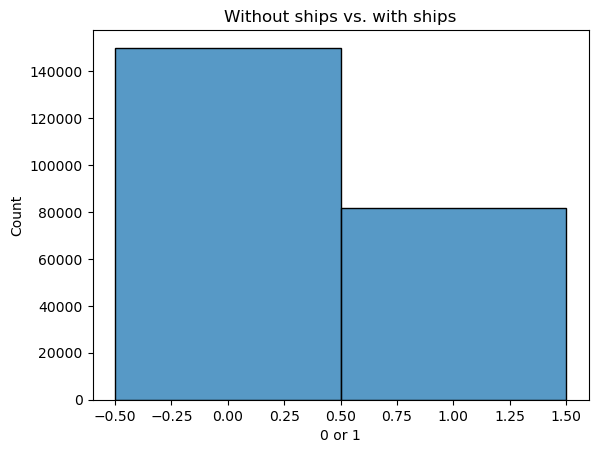

In [ ]:
sns.histplot(segmented_mask, discrete=True)
plt.title("Without ships vs. with ships")
plt.xlabel("0 or 1")

In [ ]:
print(f"With ships: {df[segmented_mask].size/(df[segmented_mask].size + df[~segmented_mask].size)}, without ships:{df[~segmented_mask].size/(df[~segmented_mask].size+ df[segmented_mask].size)}")

With ships: 0.3526753926023744, without ships:0.6473246073976257


In [ ]:
df.groupby("ImageId").count().iloc[200]

EncodedPixels    5
Name: 0041d7084.jpg, dtype: int64

In [ ]:
df_summary.ship_count.iloc[200]

np.int64(5)

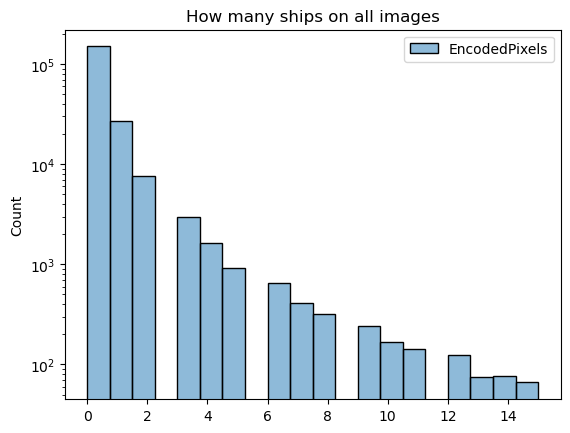

In [ ]:
sns.histplot(df.groupby("ImageId").count(), bins=20)
plt.title("How many ships on all images")
plt.yscale('log')

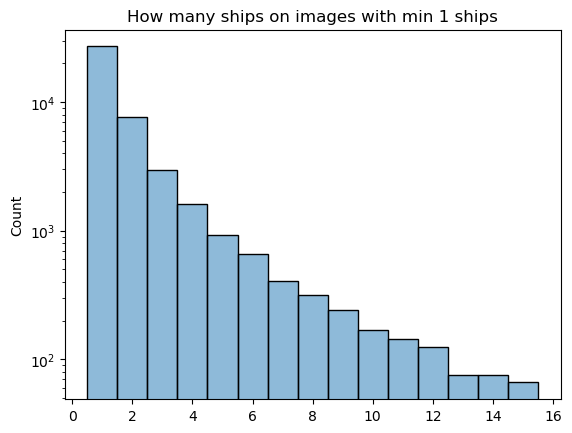

In [ ]:
sns.histplot(df[segmented_mask].groupby("ImageId").count(), discrete=True, legend=False)
plt.title("How many ships on images with min 1 ships")
plt.yscale('log')

### Statement:
- There are more non-empty ship images than empty ship images, so the database must be balanced to prevent the model from overfitting on the set of non-segmented images during training.
- This must be solved using data augmentation methods.

## Undersampling

0         00003e153.jpg
1         0001124c7.jpg
2         000155de5.jpg
3         000194a2d.jpg
4         000194a2d.jpg
              ...      
231718    fffedbb6b.jpg
231719    ffff2aa57.jpg
231720    ffff6e525.jpg
231721    ffffc50b4.jpg
231722    ffffe97f3.jpg
Name: ImageId, Length: 231723, dtype: object

In [ ]:
df_summary = ship_count.reset_index().rename(columns={'EncodedPixels': 'ship_count'})
df_summary['has_ship'] = (df_summary['ship_count'] > 0).astype(int)

In [ ]:
empty = df_summary[df_summary['has_ship'] == 0]
non_empty = df_summary[df_summary['has_ship'] == 1]

empty_sample = empty.sample(len(non_empty), random_state=42)

balanced_df = pd.concat([empty_sample, non_empty])

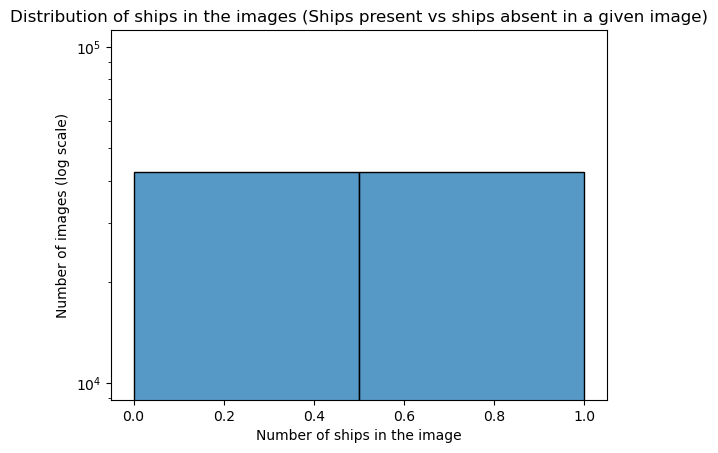

In [ ]:
sns.histplot(balanced_df['has_ship'], bins=2)
plt.yscale('log')
plt.xlabel('Number of ships in the image')
plt.ylabel('Number of images (log scale)')
plt.title('Distribution of ships in the images (Ships present vs ships absent in a given image)')
plt.show()

In [ ]:
multi_ship = df_summary[df_summary['ship_count'] > 1]
multi_ship_oversampled = resample(
    multi_ship,
    replace = True,
    n_samples= len(multi_ship)*3,
    random_state=42   
)
balanced_df = pd.concat( [empty_sample,non_empty,multi_ship_oversampled])

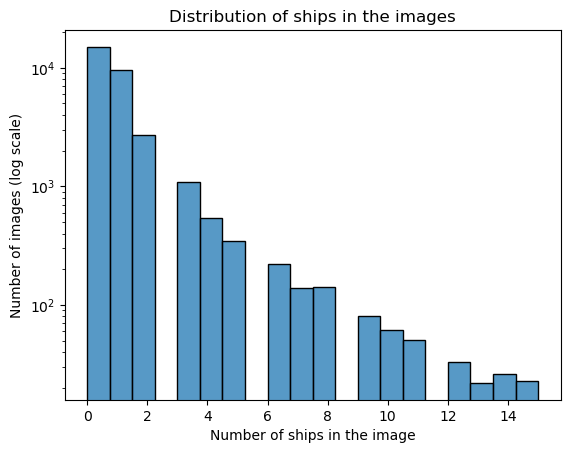

In [ ]:
sns.histplot(balanced_df['ship_count'], bins=20)
plt.yscale('log')
plt.xlabel('Number of ships in the image')
plt.ylabel('Number of images (log scale)')
plt.title('Distribution of ships in the images')
plt.show()

## Division into training, validation, and test sets

Two versions:
- 1. The test data is already in the database, but it does not have a label, which means that we need to upload the data in CSV format to Kaggle so that we can check the quality of our model. So in this case, we divide 20% of the training set into the validation set.
- 2. Since the test data has no labels, which makes testing more inconvenient, we divide the training set into validation and test sets.

In [ ]:
#First version
X = balanced_df["ImageId"]
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)
#Second version
#X_train, X_val = train_test_split(X, test_size=0.4, random_state=42)
#X_val, X_test = train_test_split(X_val, test_size=0.4, random_state=42)